# EEG Data Analysis Notebook

This notebook performs analysis on EEG (Electroencephalogram) data obtained from an Emotiv EEG headset. The code is designed to handle a variable number of channels and actions, allowing for flexibility with different datasets.
- for :
 - Motor Imagery data 
 - Stress detection data 

## Overview

1. **Loading and Visualization:**
    - The code starts by loading EEG data from a MATLAB file into a Pandas DataFrame. The number of channels, channel names, actions, and action names are specified by the user. The raw EEG data is visualized in subplots, with each subplot representing a different channel.

2. **Data Division and Saving:**
    - The EEG data is divided into different dataframes based on the actions recorded. Each dataframe corresponds to a specific action and is saved as a separate CSV file in a specified directory.


3. **Similarity Calculation:**
    - The code calculates self-similarity and cross-similarity between different actions based on EEG data. The results are visualized in a heatmap.

<!-- ## Instructions for Use

To use this notebook with your EEG dataset, follow these steps:

1. Replace the `mat_file` variable with the path to your MATLAB file containing EEG data.
2. Specify the `variable_name_key` corresponding to the variable containing EEG data in your MATLAB file.
3. Adjust the parameters such as `num_channels`, `channel_names`, `num_actions`, `action_names`, `action_column_index`, `save_directory`, and `remove_columns` according to your dataset.

Feel free to explore and modify the code to suit your specific EEG data analysis requirements. -->


#### Importing Libaraies 

In [4]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from scipy.signal import stft
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


# EEG MI Data (Motor Imagery)
####  EEG Raw Data Classification by Action
-  EEG headset,
Emotiv Epoc+ headset. The headset contains 14 channels
and the sampling rate is 128 Hz
-  The channels named: AF3 F7 F3 FC5 T7 P7 O1 O2 P8 T8 FC6 F4 F8 AF4 
- emotiv_7sub_5class, 7sub, each 34560 samples,  the data in this file folders, are ordered by label.  
Each row of the data contain 16 elements: 1-14 are denote 14 channel EEG raw data, the 15th denotes the label of classes, the 16th column denotes the label of subject.



| Action ID | Action Name   |
|-----------|---------------|
| 1         | up            |
| 2         | down          |
| 3         | left          |
| 4         | right         |
| 5         | middle        |
| 6         | eye close     |


| Anatomical Region | Channels                        | Function                                |
| ----------------- | ------------------------------- | --------------------------------------- |
| Frontal           | AF3, F7, F3, FC5, FC6, F4, F8, AF4 | Executive functions, motor planning, cognitive tasks |
| Temporal          | T7, T8                          | Auditory processing, memory             |
| Parietal          | P7, P8                          | Sensory integration, spatial processing |
| Occipital         | O1, O2                          | Visual processing, perception          |


#### Load Matlab file 

In [5]:
# Load the MATLAB file
mat_data = loadmat('emotiv_7sub_5class.mat')


#### Convert it into Pandas DataFrame

In [6]:

variable_name = mat_data['emotiv_7sub_5class']
# #variable_name = mat_data[list(mat_data.keys())[0]]
df = pd.DataFrame(variable_name)
df = pd.DataFrame(variable_name, columns=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'Action','Subject'])

# Print the updated column names
print("Updated Column Names:", df.columns)

df.head(10)

Updated Column Names: Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4', 'Action', 'Subject'],
      dtype='object')


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Action,Subject
0,4152.307617,4158.461426,4150.769043,4153.846191,4145.641113,4153.846191,4151.281738,4151.281738,4149.743652,4163.076660,4156.922852,4148.205078,4170.256348,4154.358887,1.0,1.0
1,4152.307617,4155.384277,4154.871582,4151.281738,4150.769043,4151.794922,4152.820312,4152.820312,4152.820312,4157.436035,4155.384277,4152.307617,4168.205078,4154.871582,1.0,1.0
2,4154.871582,4161.025391,4157.948730,4155.897461,4155.897461,4149.743652,4156.922852,4167.692383,4163.076660,4165.641113,4166.666504,4152.820312,4174.871582,4162.563965,1.0,1.0
3,4154.358887,4158.974121,4154.871582,4157.436035,4156.922852,4150.769043,4154.358887,4165.641113,4169.230469,4171.281738,4172.307617,4152.307617,4179.487305,4169.743652,1.0,1.0
4,4154.358887,4153.846191,4154.358887,4156.410156,4157.948730,4155.384277,4154.871582,4157.436035,4170.256348,4179.487305,4173.333008,4157.436035,4177.436035,4170.256348,1.0,1.0
5,4148.717773,4150.769043,4149.743652,4146.666504,4150.769043,4149.230469,4156.922852,4158.974121,4166.666504,4184.615234,4163.589844,4153.333008,4168.205078,4160.512695,1.0,1.0
6,4140.512695,4152.307617,4140.000000,4142.051270,4147.179199,4141.538574,4149.743652,4154.358887,4151.281738,4163.589844,4142.563965,4137.436035,4152.307617,4148.205078,1.0,1.0
7,4143.589844,4154.358887,4141.538574,4147.179199,4152.820312,4148.717773,4143.589844,4149.230469,4146.153809,4146.153809,4141.538574,4137.436035,4152.307617,4150.769043,1.0,1.0
8,4153.846191,4153.846191,4150.769043,4146.666504,4154.871582,4152.307617,4147.179199,4154.871582,4154.871582,4156.922852,4155.384277,4152.307617,4174.358887,4167.179199,1.0,1.0
9,4162.051270,4160.000000,4154.871582,4144.615234,4150.256348,4140.512695,4144.615234,4151.281738,4150.256348,4160.000000,4158.974121,4160.000000,4188.717773,4175.384277,1.0,1.0


In [7]:

df.shape

(241920, 16)

 emotiv_7sub_5class, 7sub, each 34560 samples,  the data in this file folders, are ordered by label.  
Each row of the data contain 16 elements: 1-14 are denote 14 channel EEG raw data, the 15th denotes the label of classes, the 16th column denotes the label of subject.


 The channels named: AF3 F7 F3 FC5 T7 P7 O1 O2 P8 T8 FC6 F4 F8 AF4

## Plotting in time domain

In [16]:

def plot_eeg_data(df, indices):
    selected_rows = slice(indices[0], indices[1])
    selected_channels = slice(0, 14)
    data_to_plot = df.iloc[selected_rows, selected_channels].values

    # channel names
    channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

    # channels to be plotted in red
    red_channels = ['AF3', 'F7', 'F3', 'FC5', 'FC6', 'F4', 'F8', 'AF4']

    # a time vector
    time_vector = np.arange(indices[0] + 1, indices[1] + 1)

    # Plot each channel separately on subplots
    fig, axs = plt.subplots(7, 2, figsize=(10, 15))

    for i in range(14):
        row = i // 2
        col = i % 2
        color = 'red' if channel_names[i] in red_channels else 'blue'
        axs[row, col].plot(time_vector, data_to_plot[:, i], color=color)
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('EEG microvolts (µV) ')
        axs[row, col].set_title(f'EEG Raw Data for {channel_names[i]}')
        axs[row, col].grid(True)

    # Adjust layout
    plt.suptitle(f'EEG Raw Data for Samples {indices[0]} to {indices[1]} for down command')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


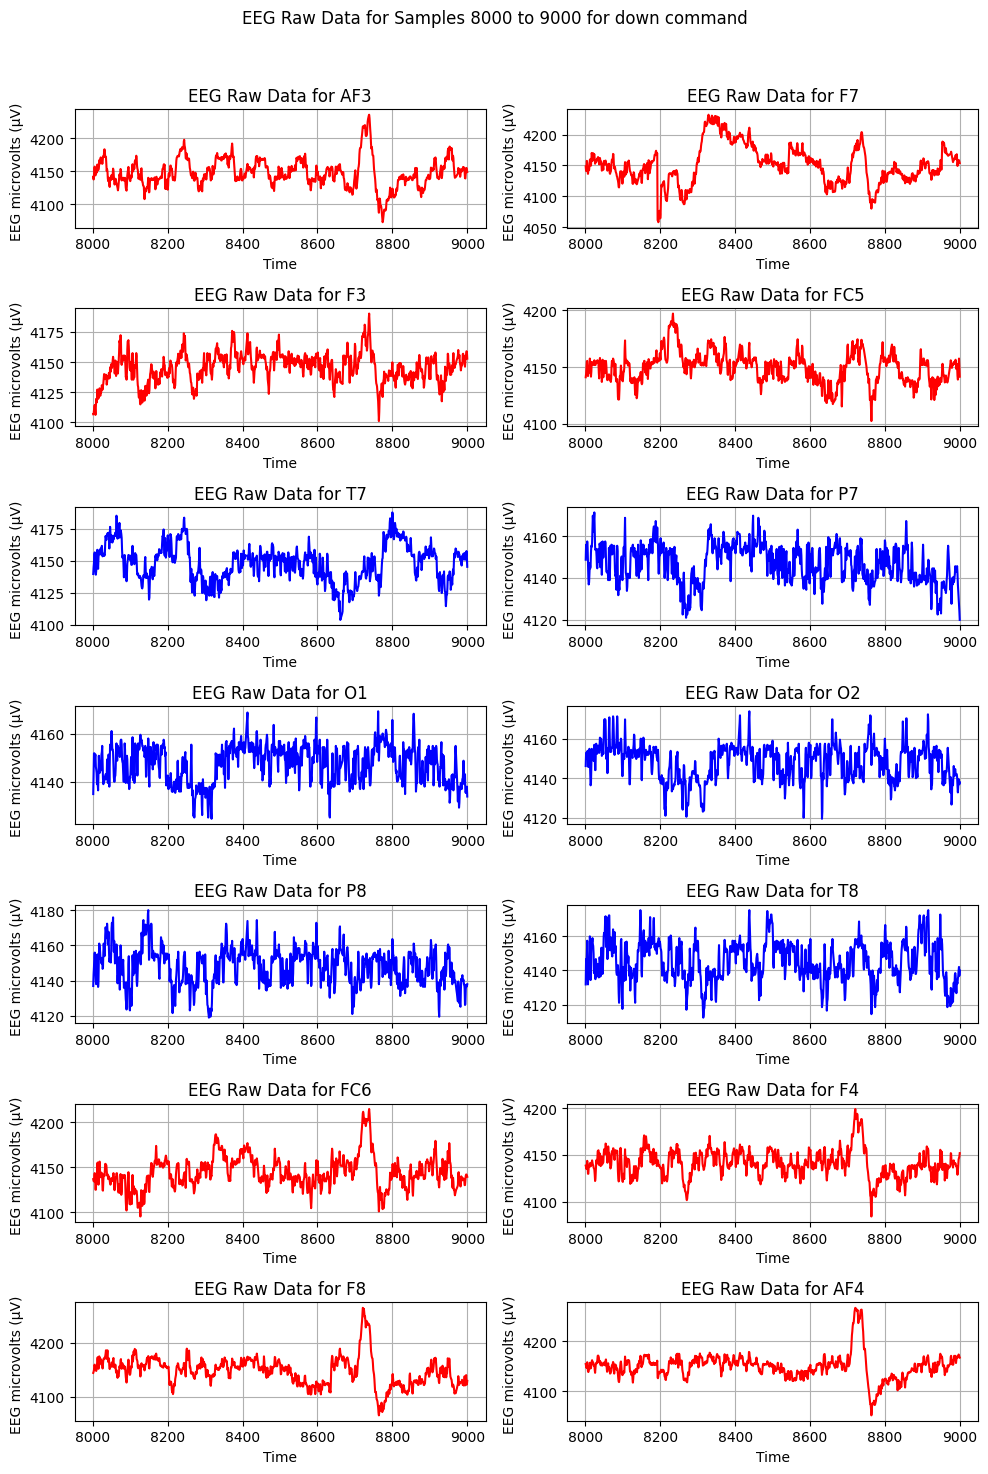

In [17]:

plot_eeg_data(df, [8000, 9000])


## Plotting in Frequency domain

| Brain Wave   | Frequency Range | Amplitude Range | Characteristics                                    | Associated Region                    | Activity State                      |
|--------------|------------------|------------------|----------------------------------------------------|--------------------------------------|-------------------------------------|
| Delta        | 0.5-4 Hz         | 20-200 μV        | Low frequency, high voltage, deep sleep             | Mainly during deep sleep           | Also observed when awake            |
| Theta        | 4-8 Hz           | > 20 μV          | Low frequency, thalamic association, sleep states   | Thalamic region                     | Sleep states, drowsiness, stimuli   |
| Alpha        | 8-13 Hz          | 30-50 μV         | Relaxed awareness, active with closed eyes          | Occipital cortex (posterior brain)   | Relaxed awareness                   |
| Beta         | 13-30 Hz         | 5-30 μV          | Active cognitive state, attentive                   | Frontal cortex                      | Active cognitive state              |
| Gamma        | 30 Hz and above  | ≤ 5 μV           | High frequency, low amplitude, integration of stimuli | Frontal cortex                      | High concentration levels           |


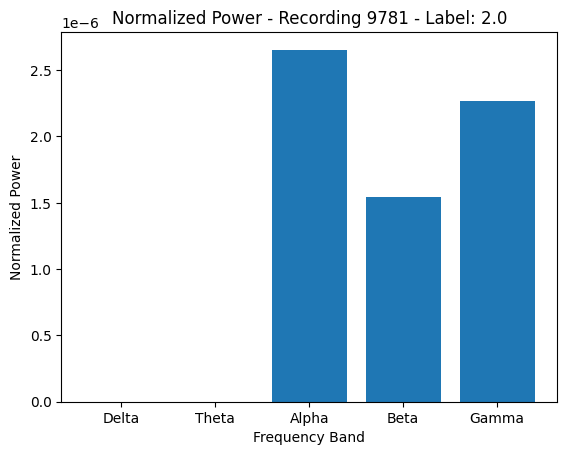

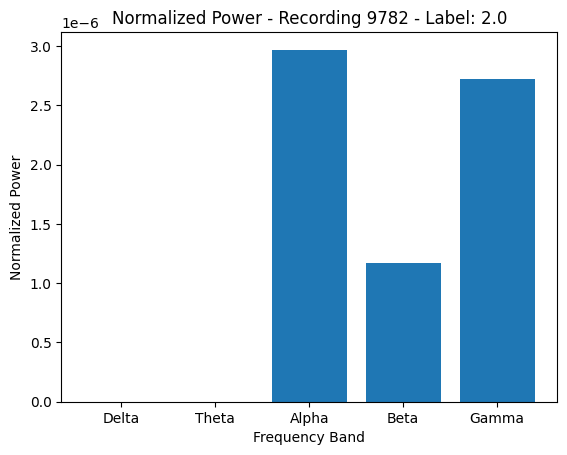

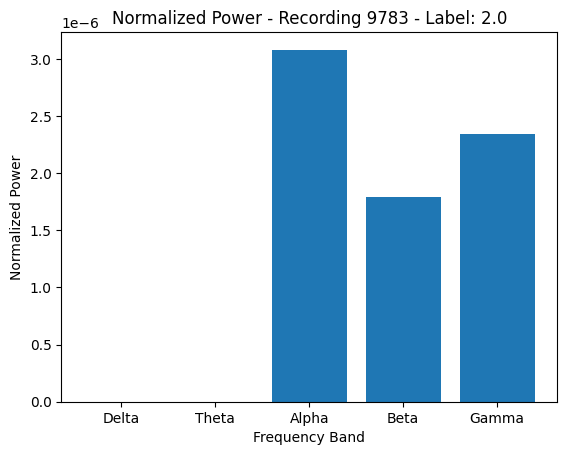

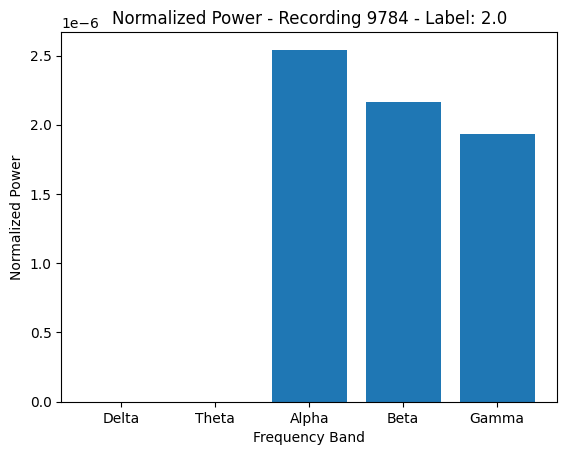

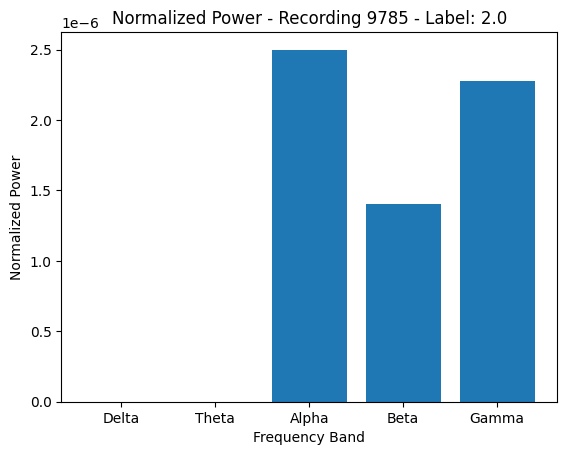

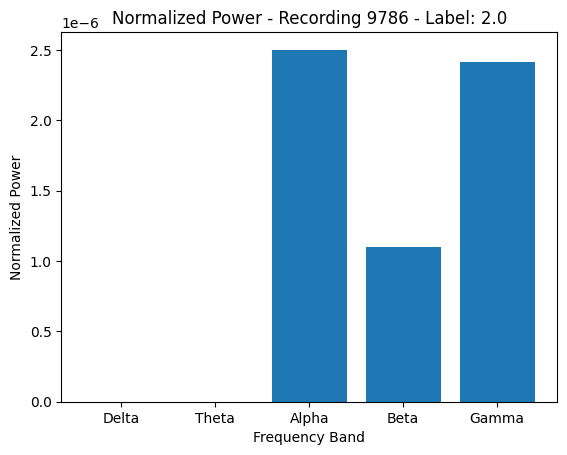

In [ ]:
def analyze_eeg_data(eeg_data, start_row, end_row):
    # Define frequency bands
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)
    gamma_band = (30, np.inf)

    # Assuming the sampling rate is fs (replace it with your actual sampling rate)
    fs = 128

    # Loop through specified range of rows
    for recording_index in range(start_row, end_row):
        # Extract EEG data and label for the current recording
        eeg_data_single_recording = eeg_data.iloc[recording_index, :-2]
        label_single_recording = eeg_data.iloc[recording_index, -2]

        # Apply FFT
        fft_result = np.fft.fft(eeg_data_single_recording)
        fft_result = np.abs(fft_result)  # Get amplitude information

        # Calculate frequency values
        freq_values = np.fft.fftfreq(len(eeg_data_single_recording), 1/fs)

        # Calculate power spectrum
        power_spectrum = fft_result**2

        # Sum power within frequency bands
        total_power = np.sum(power_spectrum)
        delta_power = np.sum(power_spectrum[(freq_values >= delta_band[0]) & (freq_values <= delta_band[1])])
        theta_power = np.sum(power_spectrum[(freq_values >= theta_band[0]) & (freq_values <= theta_band[1])])
        alpha_power = np.sum(power_spectrum[(freq_values >= alpha_band[0]) & (freq_values <= alpha_band[1])])
        beta_power = np.sum(power_spectrum[(freq_values >= beta_band[0]) & (freq_values <= beta_band[1])])
        gamma_power = np.sum(power_spectrum[freq_values >= gamma_band[0]])

        # Normalize power values
        delta_power_normalized = delta_power / total_power
        theta_power_normalized = theta_power / total_power
        alpha_power_normalized = alpha_power / total_power
        beta_power_normalized = beta_power / total_power
        gamma_power_normalized = gamma_power / total_power

        # Bar plot for each normalized power value
        freq_bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
        normalized_powers = [delta_power_normalized, theta_power_normalized, alpha_power_normalized,
                             beta_power_normalized, gamma_power_normalized]

        plt.bar(freq_bands, normalized_powers)
        plt.xlabel('Frequency Band')
        plt.ylabel('Normalized Power')
        plt.title(f'Normalized Power - Recording {recording_index + 1} - Label: {label_single_recording}')
        
        plt.show()

# Assuming eeg_data is a DataFrame containing your EEG data
# Specify the range of rows to analyze (e.g., from row 10 to 20)
start_row = 9780
end_row = 9786
analyze_eeg_data(df, start_row, end_row)


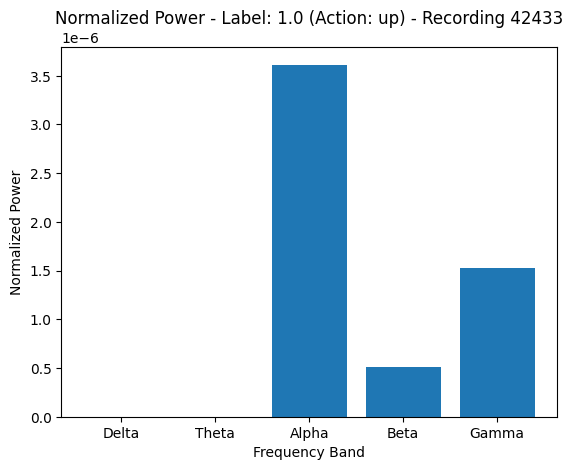

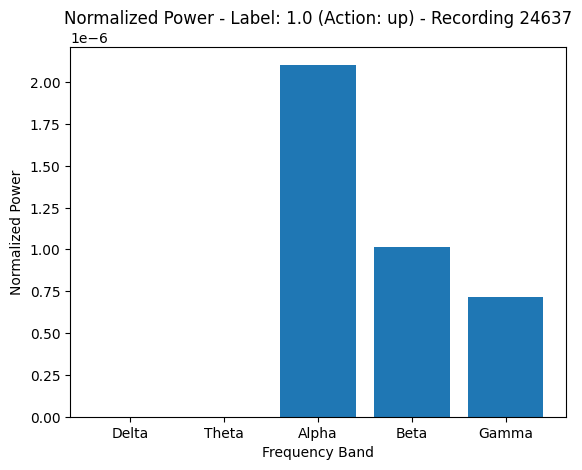

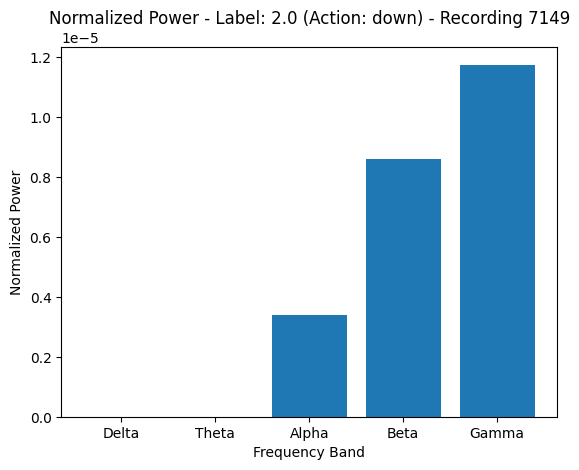

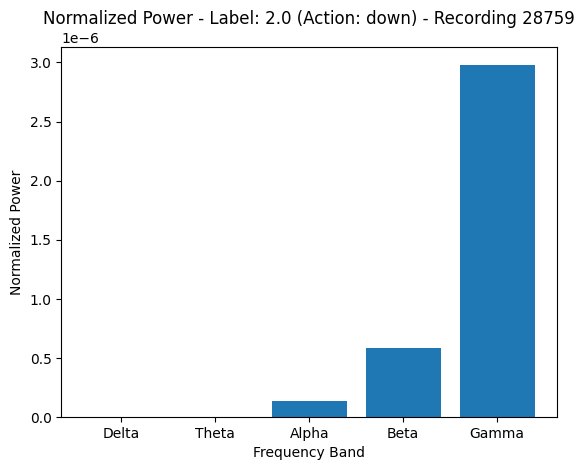

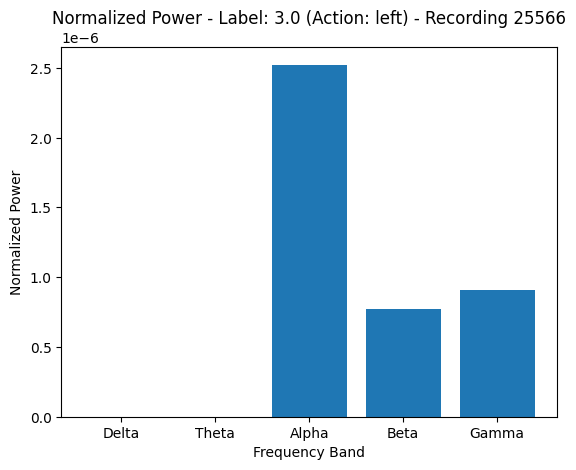

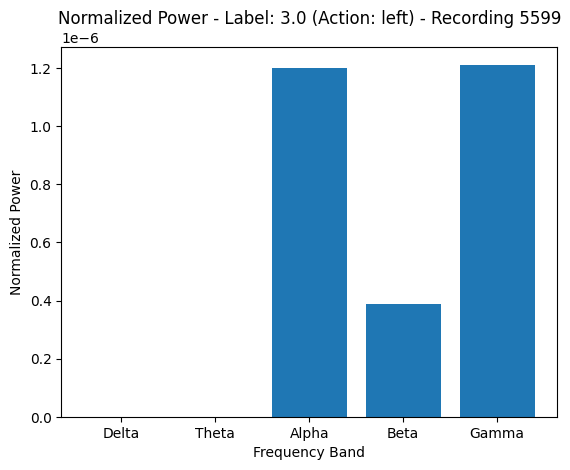

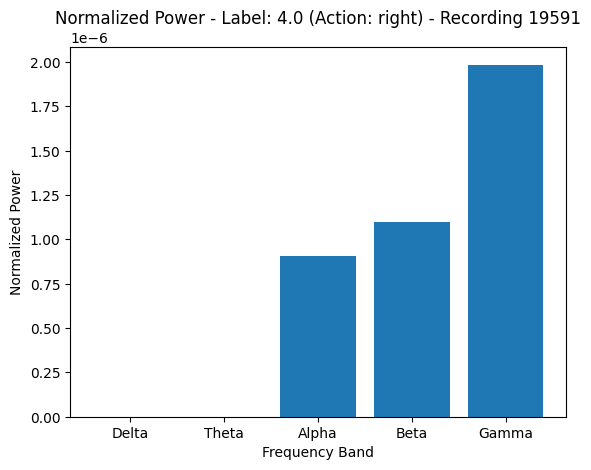

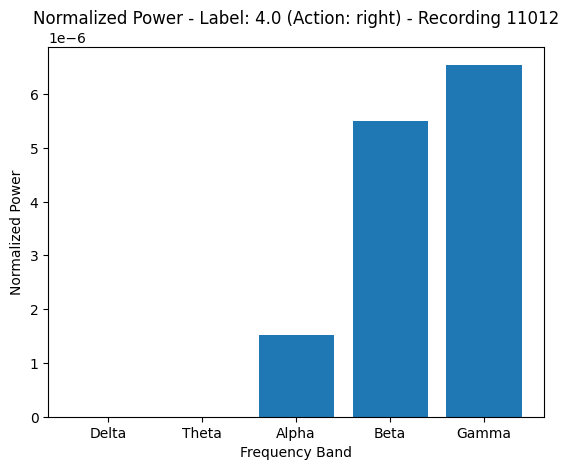

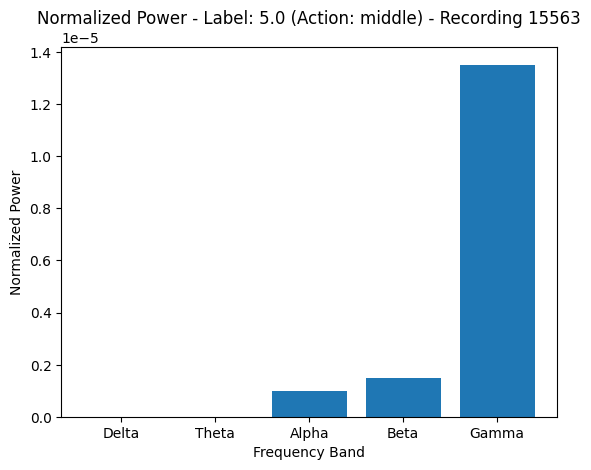

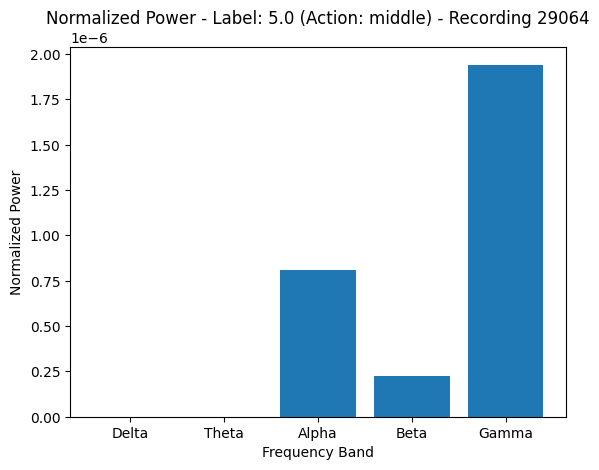

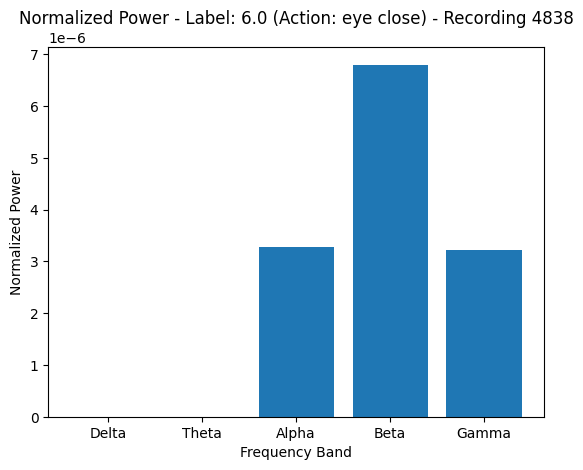

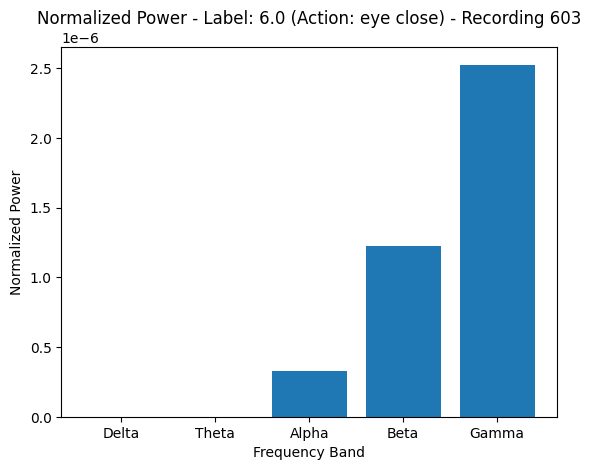

In [ ]:


def analyze_eeg_by_label(df, label_column, num_rows_per_action, action_mapping):
    # Define frequency bands
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)
    gamma_band = (30, 50)

    # Assuming the sampling rate is fs (replace it with your actual sampling rate)
    fs = 128

    # Iterate through unique labels
    unique_labels = df[label_column].unique()
    for label_value in unique_labels:
        # Filter rows based on the current label
        label_rows = df[df[label_column] == label_value]

        # Randomly select two rows for the current label
        selected_rows = random.sample(range(len(label_rows)), min(num_rows_per_action, len(label_rows)))

        # Iterate through selected rows
        for recording_index in selected_rows:
            # Extract EEG data and label for the current recording
            eeg_data_single_recording = label_rows.iloc[recording_index, :-2]
            label_single_recording = label_rows.iloc[recording_index, -2]

            # Apply FFT
            fft_result = np.fft.fft(eeg_data_single_recording)
            fft_result = np.abs(fft_result)  # Get amplitude information

            # Calculate frequency values
            freq_values = np.fft.fftfreq(len(eeg_data_single_recording), 1/fs)

            # Calculate power spectrum
            power_spectrum = fft_result**2

            # Sum power within frequency bands
            total_power = np.sum(power_spectrum)
            delta_power = np.sum(power_spectrum[(freq_values >= delta_band[0]) & (freq_values <= delta_band[1])])
            theta_power = np.sum(power_spectrum[(freq_values >= theta_band[0]) & (freq_values <= theta_band[1])])
            alpha_power = np.sum(power_spectrum[(freq_values >= alpha_band[0]) & (freq_values <= alpha_band[1])])
            beta_power = np.sum(power_spectrum[(freq_values >= beta_band[0]) & (freq_values <= beta_band[1])])
            gamma_power = np.sum(power_spectrum[freq_values >= gamma_band[0]])

            # Normalize power values
            delta_power_normalized = delta_power / total_power
            theta_power_normalized = theta_power / total_power
            alpha_power_normalized = alpha_power / total_power
            beta_power_normalized = beta_power / total_power
            gamma_power_normalized = gamma_power / total_power

            # Bar plot for each normalized power value
            freq_bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
            normalized_powers = [delta_power_normalized, theta_power_normalized, alpha_power_normalized,
                                 beta_power_normalized, gamma_power_normalized]

            # Get the Action Name based on the Action ID
            action_id = int(label_single_recording)
            action_name = action_mapping.get(action_id, f'Unknown Action {action_id}')

            # Plotting
            plt.bar(freq_bands, normalized_powers)
            plt.xlabel('Frequency Band')
            plt.ylabel('Normalized Power')
            plt.title(f'Normalized Power - Label: {label_value} (Action: {action_name}) - Recording {recording_index + 1}')
            plt.show()

# Example usage
# Assuming df is your DataFrame and 'Action' is the label column
# You can replace 'Action' with your actual label column name
# action_mapping is a dictionary mapping Action IDs to Action Names
action_mapping = {1: 'up', 2: 'down', 3: 'left', 4: 'right', 5: 'middle', 6: 'eye close'}

# Specify the number of rows per action to analyze
num_rows_per_action = 2

analyze_eeg_by_label(df, 'Action', num_rows_per_action, action_mapping)


### Dataframe in Frequency domain

In [ ]:
import pandas as pd
import numpy as np

def fft_dataframe(df, label_column, action_mapping):
    # Define frequency bands
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)
    gamma_band = (30, 50)

    # Assuming the sampling rate is fs (replace it with your actual sampling rate)
    fs = 128

    # Create a new DataFrame for FFT values
    fft_columns = ['Action', 'Subject', 'Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    fft_df = pd.DataFrame(columns=fft_columns)

    # Iterate through rows of the original DataFrame
    for index, row in df.iterrows():
        # Extract 'Action' and 'Subject' columns
        action_value = row['Action']
        subject_value = row['Subject']

        # Extract EEG data for the current row
        eeg_data_single_row = row[:-2]  # Assuming the last two columns are 'Action' and 'Subject'

        # Apply FFT
        fft_result = np.fft.fft(eeg_data_single_row)
        fft_result = np.abs(fft_result)  # Get amplitude information

        # Calculate frequency values
        freq_values = np.fft.fftfreq(len(eeg_data_single_row), 1/fs)

        # Calculate power spectrum
        power_spectrum = fft_result**2

        # Sum power within frequency bands
        total_power = np.sum(power_spectrum)
        delta_power = np.sum(power_spectrum[(freq_values >= delta_band[0]) & (freq_values <= delta_band[1])])
        theta_power = np.sum(power_spectrum[(freq_values >= theta_band[0]) & (freq_values <= theta_band[1])])
        alpha_power = np.sum(power_spectrum[(freq_values >= alpha_band[0]) & (freq_values <= alpha_band[1])])
        beta_power = np.sum(power_spectrum[(freq_values >= beta_band[0]) & (freq_values <= beta_band[1])])
        gamma_power = np.sum(power_spectrum[(freq_values >= gamma_band[0]) & (freq_values <= gamma_band[1])])

        # Normalize power values
        delta_power_normalized = delta_power / total_power
        theta_power_normalized = theta_power / total_power
        alpha_power_normalized = alpha_power / total_power
        beta_power_normalized = beta_power / total_power
        gamma_power_normalized = gamma_power / total_power

        # Append the normalized power values, 'Action', and 'Subject' to the new DataFrame
        row_data = {
            'Action': action_value,
            'Subject': subject_value,
            'Delta': delta_power_normalized,
            'Theta': theta_power_normalized,
            'Alpha': alpha_power_normalized,
            'Beta': beta_power_normalized,
            'Gamma': gamma_power_normalized
        }
        fft_df = pd.concat([fft_df, pd.DataFrame([row_data])], ignore_index=True)

    return fft_df

# Example usage
# Assuming df is your original DataFrame and 'Action' is the label column
# You can replace 'Action' with your actual label column name
# action_mapping is a dictionary mapping Action IDs to Action Names
action_mapping = {1: 'up', 2: 'down', 3: 'left', 4: 'right', 5: 'middle', 6: 'eye close'}

# Create the FFT DataFrame
fft_result_df = fft_dataframe(df, 'Action', action_mapping)




KeyboardInterrupt: 

,Action,Subject,Delta,Theta,Alpha,Beta,Gamma
0,1.0,1.0,0.0,0.0,2.510444e-07,2.114483e-09,5.750930e-07
1,1.0,1.0,0.0,0.0,1.600875e-07,4.433115e-08,2.390376e-07
2,1.0,1.0,0.0,0.0,3.935754e-07,2.368651e-07,4.883143e-07
3,1.0,1.0,0.0,0.0,9.404121e-07,4.445414e-07,5.963550e-07
4,1.0,1.0,0.0,0.0,1.337669e-06,5.330870e-07,4.795523e-07
...,...,...,...,...,...,...,...
695,1.0,1.0,0.0,0.0,1.518297e-05,2.059453e-06,1.730958e-06
696,1.0,1.0,0.0,0.0,1.290005e-05,1.185497e-06,1.998098e-06
697,1.0,1.0,0.0,0.0,1.417940e-05,1.321864e-06,2.227773e-06
698,1.0,1.0,0.0,0.0,1.676778e-05,1.915092e-06,1.730839e-06


## Dividing the dataframe into several dataframes depending on the action 

In [ ]:
# Extract the 16th column (assuming 0-based indexing)
action_column = df.iloc[:, 15]

# Define the action names
action_names = ['up', 'down', 'left', 'right', 'middle', 'eye close']

# Define the channel names
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

# Create a dictionary to store dataframes for each action
action_dataframes = {}

# Loop through each unique value in the action column
for action_id in range(1, 7):
    # Filter rows for the current action_id
    rows_for_action = variable_name[action_column == action_id]

    # Create a dataframe for the current action, excluding the 15th column
    action_df = pd.DataFrame(rows_for_action[:, :-1], columns=channel_names + ['Subject'])

    # Add Action ID and Action Name columns
    action_df['Action ID'] = action_id
    action_df['Action Name'] = action_names[action_id - 1]

    # Store the dataframe in the dictionary
    action_dataframes[action_id] = action_df

# Print the first few rows of each dataframe
for action_id, action_df in action_dataframes.items():
    print(f'\nAction ID: {action_id} - Action Name: {action_names[action_id - 1]}')
    display(action_df.head())


Action ID: 1 - Action Name: up


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Subject,Action ID,Action Name
0,4152.307617,4158.461426,4150.769043,4153.846191,4145.641113,4153.846191,4151.281738,4151.281738,4149.743652,4163.076660,4156.922852,4148.205078,4170.256348,4154.358887,1.0,1,up
1,4152.307617,4155.384277,4154.871582,4151.281738,4150.769043,4151.794922,4152.820312,4152.820312,4152.820312,4157.436035,4155.384277,4152.307617,4168.205078,4154.871582,1.0,1,up
2,4154.871582,4161.025391,4157.948730,4155.897461,4155.897461,4149.743652,4156.922852,4167.692383,4163.076660,4165.641113,4166.666504,4152.820312,4174.871582,4162.563965,1.0,1,up
3,4154.358887,4158.974121,4154.871582,4157.436035,4156.922852,4150.769043,4154.358887,4165.641113,4169.230469,4171.281738,4172.307617,4152.307617,4179.487305,4169.743652,1.0,1,up
4,4154.358887,4153.846191,4154.358887,4156.410156,4157.948730,4155.384277,4154.871582,4157.436035,4170.256348,4179.487305,4173.333008,4157.436035,4177.436035,4170.256348,1.0,1,up



Action ID: 2 - Action Name: down


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Subject,Action ID,Action Name
0,4120.512695,4121.025391,4104.615234,4099.487305,4152.820312,4145.127930,4152.307617,4133.846191,4148.717773,4138.974121,4108.717773,4164.615234,4116.922852,4150.256348,1.0,2,down
1,4144.615234,4139.487305,4108.717773,4116.410156,4158.461426,4152.307617,4155.384277,4136.922852,4156.410156,4137.948730,4122.051270,4170.256348,4133.333008,4162.563965,1.0,2,down
2,4154.358887,4145.641113,4106.666504,4124.102539,4148.717773,4156.410156,4152.820312,4137.436035,4161.538574,4130.256348,4125.641113,4167.692383,4132.820312,4161.538574,1.0,2,down
3,4145.127930,4139.487305,4106.666504,4113.846191,4136.922852,4145.127930,4144.102539,4128.717773,4146.153809,4115.897461,4110.256348,4158.974121,4113.333008,4146.666504,1.0,2,down
4,4146.666504,4139.487305,4111.281738,4112.307617,4144.615234,4138.974121,4136.922852,4118.461426,4128.205078,4103.076660,4105.641113,4156.410156,4112.820312,4147.179199,1.0,2,down



Action ID: 3 - Action Name: left


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Subject,Action ID,Action Name
0,4149.743652,4136.922852,4138.461426,4134.358887,4140.000000,4146.666504,4141.025391,4141.538574,4141.538574,4128.205078,4135.384277,4142.563965,4151.281738,4143.589844,1.0,3,left
1,4149.230469,4137.436035,4136.410156,4129.230469,4143.076660,4144.102539,4140.000000,4148.205078,4148.717773,4138.974121,4140.512695,4150.256348,4155.384277,4146.666504,1.0,3,left
2,4155.897461,4156.922852,4141.025391,4136.410156,4143.076660,4144.615234,4143.076660,4148.717773,4158.461426,4148.205078,4154.358887,4160.000000,4164.615234,4166.666504,1.0,3,left
3,4157.436035,4159.487305,4145.127930,4140.000000,4143.076660,4147.692383,4137.948730,4145.127930,4163.076660,4150.769043,4154.871582,4156.410156,4165.127930,4168.717773,1.0,3,left
4,4151.281738,4145.127930,4151.281738,4139.487305,4143.589844,4148.717773,4144.615234,4153.846191,4170.256348,4158.461426,4156.410156,4155.897461,4163.076660,4158.461426,1.0,3,left



Action ID: 4 - Action Name: right


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Subject,Action ID,Action Name
0,4138.974121,4097.436035,4208.717773,4068.205078,4107.179199,4105.127930,4108.717773,4104.615234,4101.025391,4090.769043,4060.512695,4093.333252,4092.820312,4129.230469,1.0,4,right
1,4132.307617,4101.025391,4211.281738,4070.769043,4104.102539,4108.205078,4109.230469,4104.615234,4104.102539,4092.820312,4052.820312,4088.717773,4087.692139,4124.615234,1.0,4,right
2,4124.615234,4107.692383,4208.205078,4075.897217,4106.666504,4112.307617,4107.179199,4101.025391,4110.769043,4101.025391,4052.307617,4085.128174,4092.820312,4127.179199,1.0,4,right
3,4118.461426,4102.051270,4197.436035,4069.230713,4109.230469,4109.743652,4105.641113,4091.281982,4103.589844,4099.487305,4049.743408,4078.461426,4087.692139,4121.538574,1.0,4,right
4,4108.205078,4092.307617,4187.179199,4061.025635,4107.179199,4108.205078,4104.102539,4084.102539,4093.333252,4082.563965,4036.923096,4071.794678,4066.666504,4105.127930,1.0,4,right



Action ID: 5 - Action Name: middle


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Subject,Action ID,Action Name
0,4111.794922,4121.025391,4118.974121,4123.076660,4108.717773,4133.846191,4122.051270,4136.410156,4116.410156,4124.102539,4120.512695,4118.974121,4120.000000,4124.102539,1.0,5,middle
1,4097.948730,4122.051270,4115.897461,4118.461426,4105.127930,4128.717773,4120.000000,4135.384277,4106.153809,4109.743652,4120.000000,4116.410156,4111.794922,4117.436035,1.0,5,middle
2,4110.256348,4123.589844,4114.871582,4124.102539,4119.487305,4136.922852,4124.102539,4134.871582,4117.436035,4113.846191,4119.487305,4118.974121,4117.948730,4104.102539,1.0,5,middle
3,4120.512695,4122.051270,4109.230469,4125.641113,4130.256348,4142.051270,4123.589844,4135.897461,4128.205078,4127.692383,4120.512695,4121.025391,4125.641113,4107.692383,1.0,5,middle
4,4102.563965,4121.025391,4111.794922,4125.641113,4117.436035,4136.922852,4120.512695,4137.948730,4123.589844,4125.127930,4130.769043,4126.666504,4125.127930,4126.153809,1.0,5,middle



Action ID: 6 - Action Name: eye close


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Subject,Action ID,Action Name
0,4128.717773,4210.256348,4151.281738,4118.974121,4144.102539,4134.871582,4122.563965,4138.461426,4430.256348,4132.307617,4148.205078,4203.589844,4131.794922,4173.846191,1.0,6,eye close
1,4136.922852,4217.948730,4155.384277,4132.307617,4147.692383,4139.487305,4128.717773,4144.615234,4430.256348,4137.436035,4141.538574,4205.127930,4140.512695,4180.000000,1.0,6,eye close
2,4129.230469,4216.922852,4153.333008,4129.230469,4149.230469,4127.179199,4128.717773,4138.974121,4422.563965,4146.153809,4144.615234,4204.615234,4142.563965,4178.461426,1.0,6,eye close
3,4123.589844,4212.820312,4153.846191,4123.076660,4147.692383,4118.461426,4123.076660,4136.922852,4413.333008,4144.102539,4151.794922,4198.974121,4140.512695,4170.256348,1.0,6,eye close
4,4128.205078,4215.897461,4155.897461,4127.692383,4148.205078,4128.205078,4123.076660,4141.025391,4410.769043,4137.948730,4153.333008,4199.487305,4143.076660,4170.769043,1.0,6,eye close


In [ ]:

# Directory to save the CSV files
save_directory = r'/home/yara/GP/BCI/DataVisPython/Actions_dataframes'

# Loop through each dataframe and save it to a CSV file
for action_id, action_df in action_dataframes.items():
    csv_filename = f'action_{action_id}.csv'
    csv_filepath = os.path.join(save_directory, csv_filename)

    # Save the dataframe to CSV
    action_df.to_csv(csv_filepath, index=False)

    print(f'Dataframe for Action ID {action_id} saved to: {csv_filepath}')


Dataframe for Action ID 1 saved to: /home/yara/GP/BCI/DataVisPython/Actions_dataframes/action_1.csv
Dataframe for Action ID 2 saved to: /home/yara/GP/BCI/DataVisPython/Actions_dataframes/action_2.csv
Dataframe for Action ID 3 saved to: /home/yara/GP/BCI/DataVisPython/Actions_dataframes/action_3.csv
Dataframe for Action ID 4 saved to: /home/yara/GP/BCI/DataVisPython/Actions_dataframes/action_4.csv
Dataframe for Action ID 5 saved to: /home/yara/GP/BCI/DataVisPython/Actions_dataframes/action_5.csv
Dataframe for Action ID 6 saved to: /home/yara/GP/BCI/DataVisPython/Actions_dataframes/action_6.csv


In [ ]:
# Remove the last 3 columns for each dataframe
for action_id, action_df in action_dataframes.items():
    action_df = action_df.iloc[:, :-3]
    action_dataframes[action_id] = action_df

    print(f'\nAction ID: {action_id} - Action Name: {action_names[action_id - 1]}')
    display(action_df.head())



Action ID: 1 - Action Name: up


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4152.307617,4158.461426,4150.769043,4153.846191,4145.641113,4153.846191,4151.281738,4151.281738,4149.743652,4163.076660,4156.922852,4148.205078,4170.256348,4154.358887
1,4152.307617,4155.384277,4154.871582,4151.281738,4150.769043,4151.794922,4152.820312,4152.820312,4152.820312,4157.436035,4155.384277,4152.307617,4168.205078,4154.871582
2,4154.871582,4161.025391,4157.948730,4155.897461,4155.897461,4149.743652,4156.922852,4167.692383,4163.076660,4165.641113,4166.666504,4152.820312,4174.871582,4162.563965
3,4154.358887,4158.974121,4154.871582,4157.436035,4156.922852,4150.769043,4154.358887,4165.641113,4169.230469,4171.281738,4172.307617,4152.307617,4179.487305,4169.743652
4,4154.358887,4153.846191,4154.358887,4156.410156,4157.948730,4155.384277,4154.871582,4157.436035,4170.256348,4179.487305,4173.333008,4157.436035,4177.436035,4170.256348



Action ID: 2 - Action Name: down


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4120.512695,4121.025391,4104.615234,4099.487305,4152.820312,4145.127930,4152.307617,4133.846191,4148.717773,4138.974121,4108.717773,4164.615234,4116.922852,4150.256348
1,4144.615234,4139.487305,4108.717773,4116.410156,4158.461426,4152.307617,4155.384277,4136.922852,4156.410156,4137.948730,4122.051270,4170.256348,4133.333008,4162.563965
2,4154.358887,4145.641113,4106.666504,4124.102539,4148.717773,4156.410156,4152.820312,4137.436035,4161.538574,4130.256348,4125.641113,4167.692383,4132.820312,4161.538574
3,4145.127930,4139.487305,4106.666504,4113.846191,4136.922852,4145.127930,4144.102539,4128.717773,4146.153809,4115.897461,4110.256348,4158.974121,4113.333008,4146.666504
4,4146.666504,4139.487305,4111.281738,4112.307617,4144.615234,4138.974121,4136.922852,4118.461426,4128.205078,4103.076660,4105.641113,4156.410156,4112.820312,4147.179199



Action ID: 3 - Action Name: left


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4149.743652,4136.922852,4138.461426,4134.358887,4140.000000,4146.666504,4141.025391,4141.538574,4141.538574,4128.205078,4135.384277,4142.563965,4151.281738,4143.589844
1,4149.230469,4137.436035,4136.410156,4129.230469,4143.076660,4144.102539,4140.000000,4148.205078,4148.717773,4138.974121,4140.512695,4150.256348,4155.384277,4146.666504
2,4155.897461,4156.922852,4141.025391,4136.410156,4143.076660,4144.615234,4143.076660,4148.717773,4158.461426,4148.205078,4154.358887,4160.000000,4164.615234,4166.666504
3,4157.436035,4159.487305,4145.127930,4140.000000,4143.076660,4147.692383,4137.948730,4145.127930,4163.076660,4150.769043,4154.871582,4156.410156,4165.127930,4168.717773
4,4151.281738,4145.127930,4151.281738,4139.487305,4143.589844,4148.717773,4144.615234,4153.846191,4170.256348,4158.461426,4156.410156,4155.897461,4163.076660,4158.461426



Action ID: 4 - Action Name: right


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4138.974121,4097.436035,4208.717773,4068.205078,4107.179199,4105.127930,4108.717773,4104.615234,4101.025391,4090.769043,4060.512695,4093.333252,4092.820312,4129.230469
1,4132.307617,4101.025391,4211.281738,4070.769043,4104.102539,4108.205078,4109.230469,4104.615234,4104.102539,4092.820312,4052.820312,4088.717773,4087.692139,4124.615234
2,4124.615234,4107.692383,4208.205078,4075.897217,4106.666504,4112.307617,4107.179199,4101.025391,4110.769043,4101.025391,4052.307617,4085.128174,4092.820312,4127.179199
3,4118.461426,4102.051270,4197.436035,4069.230713,4109.230469,4109.743652,4105.641113,4091.281982,4103.589844,4099.487305,4049.743408,4078.461426,4087.692139,4121.538574
4,4108.205078,4092.307617,4187.179199,4061.025635,4107.179199,4108.205078,4104.102539,4084.102539,4093.333252,4082.563965,4036.923096,4071.794678,4066.666504,4105.127930



Action ID: 5 - Action Name: middle


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4111.794922,4121.025391,4118.974121,4123.076660,4108.717773,4133.846191,4122.051270,4136.410156,4116.410156,4124.102539,4120.512695,4118.974121,4120.000000,4124.102539
1,4097.948730,4122.051270,4115.897461,4118.461426,4105.127930,4128.717773,4120.000000,4135.384277,4106.153809,4109.743652,4120.000000,4116.410156,4111.794922,4117.436035
2,4110.256348,4123.589844,4114.871582,4124.102539,4119.487305,4136.922852,4124.102539,4134.871582,4117.436035,4113.846191,4119.487305,4118.974121,4117.948730,4104.102539
3,4120.512695,4122.051270,4109.230469,4125.641113,4130.256348,4142.051270,4123.589844,4135.897461,4128.205078,4127.692383,4120.512695,4121.025391,4125.641113,4107.692383
4,4102.563965,4121.025391,4111.794922,4125.641113,4117.436035,4136.922852,4120.512695,4137.948730,4123.589844,4125.127930,4130.769043,4126.666504,4125.127930,4126.153809



Action ID: 6 - Action Name: eye close


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4128.717773,4210.256348,4151.281738,4118.974121,4144.102539,4134.871582,4122.563965,4138.461426,4430.256348,4132.307617,4148.205078,4203.589844,4131.794922,4173.846191
1,4136.922852,4217.948730,4155.384277,4132.307617,4147.692383,4139.487305,4128.717773,4144.615234,4430.256348,4137.436035,4141.538574,4205.127930,4140.512695,4180.000000
2,4129.230469,4216.922852,4153.333008,4129.230469,4149.230469,4127.179199,4128.717773,4138.974121,4422.563965,4146.153809,4144.615234,4204.615234,4142.563965,4178.461426
3,4123.589844,4212.820312,4153.846191,4123.076660,4147.692383,4118.461426,4123.076660,4136.922852,4413.333008,4144.102539,4151.794922,4198.974121,4140.512695,4170.256348
4,4128.205078,4215.897461,4155.897461,4127.692383,4148.205078,4128.205078,4123.076660,4141.025391,4410.769043,4137.948730,4153.333008,4199.487305,4143.076660,4170.769043


In [ ]:
# Print the shape of each dataframe
for action_id, action_df in action_dataframes.items():
    print(f'\nAction ID: {action_id} - Action Name: {action_names[action_id - 1]}')
    print(action_df.shape)



Action ID: 1 - Action Name: up
(34560, 14)

Action ID: 2 - Action Name: down
(34560, 14)

Action ID: 3 - Action Name: left
(34560, 14)

Action ID: 4 - Action Name: right
(34560, 14)

Action ID: 5 - Action Name: middle
(34560, 14)

Action ID: 6 - Action Name: eye close
(34560, 14)


# Pearson correlation coefficient 
to measure self-similarity and cross-similarity between EEG signals corresponding to different intents. 

## Self-Similarity and Cross-Similarity Analysis

### Self-Similarity:
1. **Definition:** Self-similarity measures the similarity of EEG signals within the same intent or action category.
2. **Calculation:** Randomly select several EEG data samples from the same action category.
3. Calculate the correlation coefficient for each possible pair of samples.
4. Self-similarity for the specific action category is measured as the average of all the sample pairs' correlation coefficients.

### Cross-Similarity:
1. **Definition:** Cross-similarity measures the similarity of two samples belonging to different action categories.
2. For each specific action category:
   - Calculate the correlation coefficient for each possible pair of samples between this category and all other categories.
   - There are a total of 20 intent pairs (4 pairs for each specific intent).
3. Cross-similarity for each specific action category is the average of correlation coefficients of each intent pair.

### Overall Measurement:
1. The EEG dataset contains 6 action categories (up, down, left, right, middle, eye close).
2. The correlation coefficients matrix is created for each specific action category.
3. The self-similarity and cross-similarity results are calculated and stored for analysis.

## Visualization:
1. Heatmaps are used to visualize the self-similarity and cross-similarity matrices.
2. The self-similarity heatmap shows the average correlation coefficients within each action category.
3. The cross-similarity heatmap displays the average correlation coefficients between different action categories.


These analyses help understand the patterns of similarity within the same action category (self-similarity) and between different action categories (cross-similarity) based on EEG signals. The heatmaps and matrices provide a visual representation of the correlation coefficients, aiding in the interpretation of the EEG data in the context of human intents.


In [ ]:
from itertools import combinations

def calculate_similarity(dataframes, action_names):
    # Initialize dictionaries to store self-similarity and cross-similarity
    self_similarity = {}
    cross_similarity = {}

    # Loop through each action_id
    for action_id, action_df in dataframes.items():
        # Extract EEG data columns
        eeg_data = action_df[channel_names].values

        # Calculate self-similarity
        self_similarity[action_id] = round(np.mean(np.corrcoef(eeg_data, rowvar=False)), 2)

        # Calculate cross-similarity
        cross_similarity[action_id] = []
        for other_action_id, other_action_df in dataframes.items():
            if action_id != other_action_id:
                other_eeg_data = other_action_df[channel_names].values
                cross_corr = np.mean(np.corrcoef(eeg_data, other_eeg_data, rowvar=False))
                cross_similarity[action_id].append((other_action_id, cross_corr))

    return self_similarity, cross_similarity

# Calculate similarity
self_similarity, cross_similarity = calculate_similarity(action_dataframes, action_names)

# Print the results
# for action_id, action_name in zip(range(1, 7), action_names):
#     print(f'\nAction ID: {action_id} - Action Name: {action_name}')
#     print(f'Self-similarity: {self_similarity[action_id]}')
#     # print('Cross-similarity:')
#     # for other_action_id, cross_corr in cross_similarity[action_id]:
#     #     print(f'  - Action ID {other_action_id}: {cross_corr}')


In [ ]:
# Visualize self-similarity and cross-similarity
self_similarity_values = [self_similarity[action_id] for action_id in range(1, 7)]
self_similarity_df = pd.DataFrame(data=np.array([self_similarity_values]), columns=action_names)

cross_similarity_values = np.zeros((6, 6))
for action_id in range(1, 7):
    for other_action_id, cross_corr in cross_similarity[action_id]:
        if action_id == other_action_id:
            cross_similarity_values[action_id-1, other_action_id-1] = round(self_similarity[action_id], 2)
        else:
            cross_similarity_values[action_id-1, other_action_id-1] = round(cross_corr, 2)

cross_similarity_df = pd.DataFrame(data=cross_similarity_values, columns=action_names)

# Plotting
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # Self-similarity heatmap
# sns.heatmap(self_similarity_df, annot=True, cmap="viridis", xticklabels=action_names, yticklabels=["Self-similarity"], cbar=False, ax=axes[0])
# axes[0].set_title('Self-similarity Heatmap')

# # Cross-similarity heatmap
# sns.heatmap(cross_similarity_df, annot=True, cmap="viridis", xticklabels=action_names, yticklabels=action_names, ax=axes[1])
# axes[1].set_title('Cross-similarity Heatmap')

# plt.show()


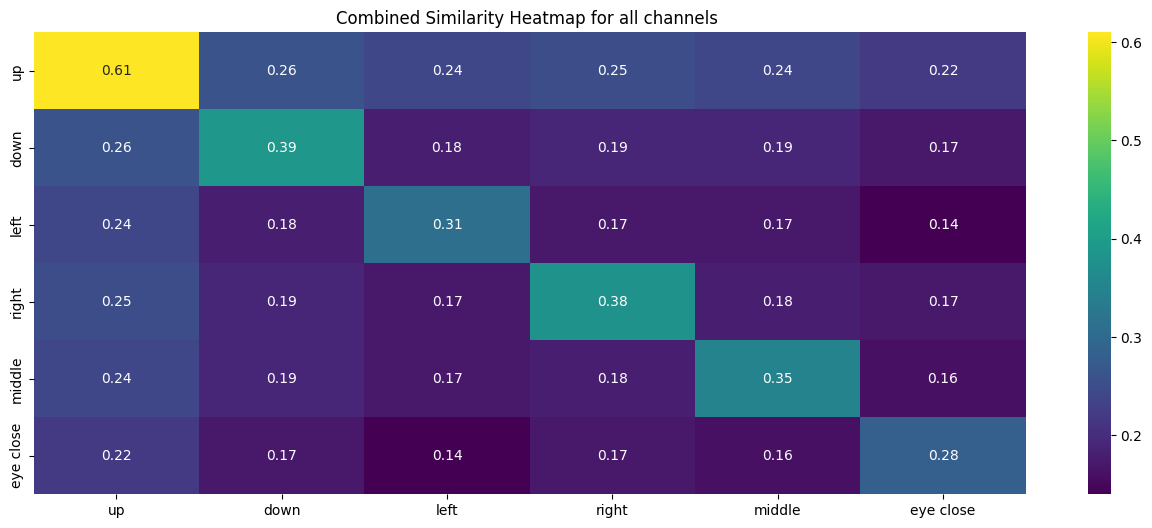

In [ ]:
# Visualize self-similarity and cross-similarity
self_similarity_values = [self_similarity[action_id] for action_id in range(1, 7)]
self_similarity_df = pd.DataFrame(data=np.array([self_similarity_values]), columns=action_names)

cross_similarity_values = np.zeros((6, 6))
for action_id in range(1, 7):
    for other_action_id, cross_corr in cross_similarity[action_id]:
        cross_similarity_values[action_id-1, other_action_id-1] = round(cross_corr, 2)

# Replace diagonal values with self-similarity values
np.fill_diagonal(cross_similarity_values, self_similarity_values)

cross_similarity_df = pd.DataFrame(data=cross_similarity_values, columns=action_names)

# Plotting
plt.figure(figsize=(16, 6))

# Combined similarity heatmap
sns.heatmap(cross_similarity_df, annot=True, cmap="viridis", xticklabels=action_names, yticklabels=action_names)
plt.title('Combined Similarity Heatmap for all channels ')

plt.show()


In [ ]:
# Define the selected channels
selected_channels = ['AF3', 'F7', 'F3', 'FC5', 'FC6', 'F4', 'F8', 'AF4']

# Generate all possible combinations of 2 channels for cross-correlation
channel_combinations = list(combinations(selected_channels, 2))

def calculate_similarity(dataframes, action_names):
    # Initialize dictionaries to store self-similarity and cross-similarity
    self_similarity = {}
    cross_similarity = {}

    # Loop through each action_id
    for action_id, action_df in dataframes.items():
        # Extract EEG data columns for selected channels
        eeg_data = action_df[selected_channels].values

        # Calculate self-similarity
        self_similarity[action_id] = round(np.mean(np.corrcoef(eeg_data, rowvar=False)), 2)

        # Calculate cross-similarity
        cross_similarity[action_id] = []
        for other_action_id, other_action_df in dataframes.items():
            if action_id != other_action_id:
                other_eeg_data = other_action_df[selected_channels].values
                cross_corr = np.mean(np.corrcoef(eeg_data, other_eeg_data, rowvar=False))
                cross_similarity[action_id].append((other_action_id, cross_corr))

    return self_similarity, cross_similarity

# Calculate similarity
self_similarity, cross_similarity = calculate_similarity(action_dataframes, action_names)

# Print the results
for action_id, action_name in zip(range(1, 7), action_names):
    print(f'\nAction ID: {action_id} - Action Name: {action_name}')
    print(f'Self-similarity: {self_similarity[action_id]}')
    print('Cross-similarity:')
    for other_action_id, cross_corr in cross_similarity[action_id]:
        print(f'  - Action ID {other_action_id}: {cross_corr}')



Action ID: 1 - Action Name: up
Self-similarity: 0.71
Cross-similarity:
  - Action ID 2: 0.28781392715442994
  - Action ID 3: 0.2854550865748116
  - Action ID 4: 0.312314357869452
  - Action ID 5: 0.2719046682163711
  - Action ID 6: 0.2537807462365651

Action ID: 2 - Action Name: down
Self-similarity: 0.44
Cross-similarity:
  - Action ID 1: 0.28781392715443
  - Action ID 3: 0.20909371592717757
  - Action ID 4: 0.2377963658340398
  - Action ID 5: 0.2110125095474114
  - Action ID 6: 0.18966896959570534

Action ID: 3 - Action Name: left
Self-similarity: 0.42
Cross-similarity:
  - Action ID 1: 0.2854550865748116
  - Action ID 2: 0.20909371592717754
  - Action ID 4: 0.24997039938921506
  - Action ID 5: 0.209520249932632
  - Action ID 6: 0.17796139566652708

Action ID: 4 - Action Name: right
Self-similarity: 0.54
Cross-similarity:
  - Action ID 1: 0.312314357869452
  - Action ID 2: 0.23779636583403982
  - Action ID 3: 0.2499703993892151
  - Action ID 5: 0.23691256196864424
  - Action ID 6: 0

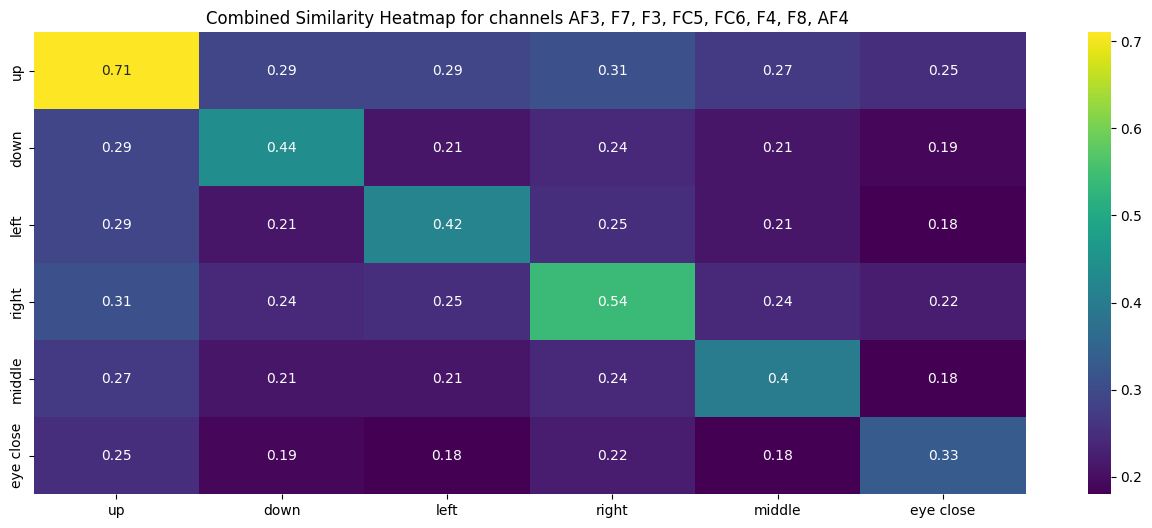

In [ ]:

# Visualize self-similarity and cross-similarity
self_similarity_values = [self_similarity[action_id] for action_id in range(1, 7)]
self_similarity_df = pd.DataFrame(data=np.array([self_similarity_values]), columns=action_names)

cross_similarity_values = np.zeros((6, 6))
for action_id in range(1, 7):
    for other_action_id, cross_corr in cross_similarity[action_id]:
        cross_similarity_values[action_id-1, other_action_id-1] = round(cross_corr, 2)

# Replace diagonal values with self-similarity values
np.fill_diagonal(cross_similarity_values, self_similarity_values)

cross_similarity_df = pd.DataFrame(data=cross_similarity_values, columns=action_names)

# Plotting
plt.figure(figsize=(16, 6))

# Combined similarity heatmap
sns.heatmap(cross_similarity_df, annot=True, cmap="viridis", xticklabels=action_names, yticklabels=action_names)
plt.title('Combined Similarity Heatmap for channels AF3, F7, F3, FC5, FC6, F4, F8, AF4 ')

plt.show()



Action ID: 1 - Action Name: up
Self-similarity: 0.78
Cross-similarity:
  - Action ID 2: 0.28142246037314506
  - Action ID 3: 0.3223390002465616
  - Action ID 4: 0.31963917259975
  - Action ID 5: 0.3009155690449003
  - Action ID 6: 0.28210311941574734

Action ID: 2 - Action Name: down
Self-similarity: 0.33
Cross-similarity:
  - Action ID 1: 0.2814224603731451
  - Action ID 3: 0.21013862911112402
  - Action ID 4: 0.2022479144860374
  - Action ID 5: 0.18872496322154325
  - Action ID 6: 0.1847638197542591

Action ID: 3 - Action Name: left
Self-similarity: 0.48
Cross-similarity:
  - Action ID 1: 0.3223390002465616
  - Action ID 2: 0.21013862911112402
  - Action ID 4: 0.25014226785039606
  - Action ID 5: 0.23227845503602912
  - Action ID 6: 0.21259729562057506

Action ID: 4 - Action Name: right
Self-similarity: 0.48
Cross-similarity:
  - Action ID 1: 0.31963917259975
  - Action ID 2: 0.2022479144860374
  - Action ID 3: 0.25014226785039606
  - Action ID 5: 0.22737652138526748
  - Action ID 6

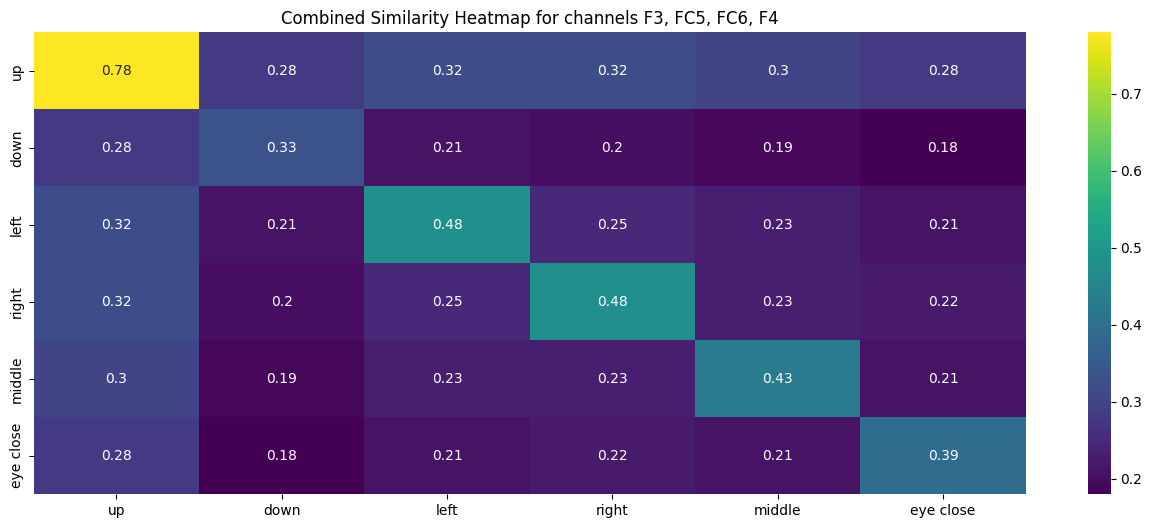

In [ ]:
# Define the selected channelsF3, FC5, FC6, F4)
selected_channels = [  'F3', 'FC5', 'FC6', 'F4']

# Generate all possible combinations of 2 channels for cross-correlation
channel_combinations = list(combinations(selected_channels, 2))

def calculate_similarity(dataframes, action_names):
    # Initialize dictionaries to store self-similarity and cross-similarity
    self_similarity = {}
    cross_similarity = {}

    # Loop through each action_id
    for action_id, action_df in dataframes.items():
        # Extract EEG data columns for selected channels
        eeg_data = action_df[selected_channels].values

        # Calculate self-similarity
        self_similarity[action_id] = round(np.mean(np.corrcoef(eeg_data, rowvar=False)), 2)

        # Calculate cross-similarity
        cross_similarity[action_id] = []
        for other_action_id, other_action_df in dataframes.items():
            if action_id != other_action_id:
                other_eeg_data = other_action_df[selected_channels].values
                cross_corr = np.mean(np.corrcoef(eeg_data, other_eeg_data, rowvar=False))
                cross_similarity[action_id].append((other_action_id, cross_corr))

    return self_similarity, cross_similarity

# Calculate similarity
self_similarity, cross_similarity = calculate_similarity(action_dataframes, action_names)

# Print the results
for action_id, action_name in zip(range(1, 7), action_names):
    print(f'\nAction ID: {action_id} - Action Name: {action_name}')
    print(f'Self-similarity: {self_similarity[action_id]}')
    print('Cross-similarity:')
    for other_action_id, cross_corr in cross_similarity[action_id]:
        print(f'  - Action ID {other_action_id}: {cross_corr}')

# Visualize self-similarity and cross-similarity
self_similarity_values = [self_similarity[action_id] for action_id in range(1, 7)]
self_similarity_df = pd.DataFrame(data=np.array([self_similarity_values]), columns=action_names)

cross_similarity_values = np.zeros((6, 6))
for action_id in range(1, 7):
    for other_action_id, cross_corr in cross_similarity[action_id]:
        cross_similarity_values[action_id-1, other_action_id-1] = round(cross_corr, 2)

# Replace diagonal values with self-similarity values
np.fill_diagonal(cross_similarity_values, self_similarity_values)

cross_similarity_df = pd.DataFrame(data=cross_similarity_values, columns=action_names)

# Plotting
plt.figure(figsize=(16, 6))

# Combined similarity heatmap
sns.heatmap(cross_similarity_df, annot=True, cmap="viridis", xticklabels=action_names, yticklabels=action_names)
plt.title('Combined Similarity Heatmap for channels F3, FC5, FC6, F4')

plt.show()


# -------------------------------------------------------------------------------------------------

# [RAW EEG STRESS DATASET](https://www.kaggle.com/datasets/ayushtibrewal/dataset-eeg)

- **Dataset Overview:**
  - SAM 40 is a dataset comprising EEG recordings from 40 subjects.
  - Subjects include 14 females and 26 males, with a mean age of 21.5 years.

- **Experimental Tasks:**
  - EEG data recorded during tasks like Stroop color-word test, arithmetic questions, mirror image recognition, and relaxation.
  - Tasks were performed for 25 seconds, repeated three times for each subject.

- **Stress Monitoring:**
  - Primary aim: Monitor short-term stress induced during cognitive tasks.
  - EEG recorded using a 32-channel Emotiv Epoc Flex gel kit.

- **Data Segmentation:**
  - EEG data segmented into non-overlapping epochs of 25 seconds based on tasks.

- **Preprocessing:**
  - Baseline drifts removed by subtracting the average trend using the Savitzky-Golay filter.
  - Artifacts removed from EEG data through wavelet thresholding.



# [STEW: SIMULTANEOUS TASK EEG WORKLOAD DATASET](https://ieee-dataport.org/open-access/stew-simultaneous-task-eeg-workload-dataset)
- from paper **[Hybrid Deep Learning Approach for Stress Detection Using Decomposed EEG Signals](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10252840/#B49-diagnostics-13-01936)**
# Data Description

## Type of Data
- 32 Channel EEG time-series data

## Data Acquisition
- Visual stimuli corresponding to different simple cognitive tasks were presented to healthy volunteers.
- Volunteers were instructed to respond according to different tasks while their EEG data were recorded.
- Visual stimuli were presented on a 24-inch monitor (Dell Inc., Texas, USA).
- EEG data were acquired with a 32-channel Emotiv Epoc Flex gel kit (Emotiv Inc., San Francisco, USA).

## Data Format
- Raw EEG time series
- Processed EEG time series

## Parameters for Data Collection
- EEG recorded from 32 channels (plus CMS/DRL references) with a dynamic range of +/- 4.12 mV.
- Resolution of 0.51 µV/bit, with a range of 14 bits.
- EEG sampled at 128 SPS (1024 Hz internal).
- Visual stimuli consisted of various images aimed at psychologically inhibiting cognitive interference ability.

## Description of Data Collection
This dataset presents a collection of electroencephalographic (EEG) data recorded from 40 subjects (female: 14, male: 26, mean age: 21.5 years). The experiment aimed to monitor short-term stress elicited while performing tasks such as the Stroop color-word test, solving arithmetic questions, identification of symmetric mirror images, and a state of relaxation. Each task was performed for 25 seconds, and three trials were recorded for each task. Subjects were presented with stimuli on a monitor placed 70 cm away. Subjects rated their stress level on a scale of 1–10 for each mental task (Table 1). EEG was recorded with a 32-channel Emotiv Epoc Flex gel kit. EEG data corresponding to tasks were segmented into non-overlapping epochs of 25 seconds. EEG data were processed to remove baseline drifts by subtracting the average trend obtained using the Savitzky-Golay filter. Artifacts were also removed from the EEG data by applying wavelet thresholding.



In [ ]:

data_directory = '/home/yara/GP/BCI/Recordings/STEW Dataset'
save_directory = '/home/yara/GP/BCI/DataVisPython'

# List to store loaded dataframes
hi_dataframes = []

for subject_number in range(1, 49):
    file_name_hi = f'sub{subject_number:02d}_hi.txt'
    path_hi = os.path.join(data_directory, file_name_hi)

    # Read the data with whitespace separator and use channel names as headers
    df_hi = pd.read_csv(path_hi, sep='\s+', header=None, names=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'])
    hi_dataframes.append(df_hi)

# Concatenate all hi_dataframes into a single DataFrame
df_stress = pd.concat(hi_dataframes, ignore_index=True)

# Save the combined DataFrame to a CSV file
df_stress.to_csv(os.path.join(save_directory, 'combined_hi_data.csv'), index=False)

# Print the first 5 rows of the DataFrame
df_stress.head(5)
df_stress.shape



(921600, 14)

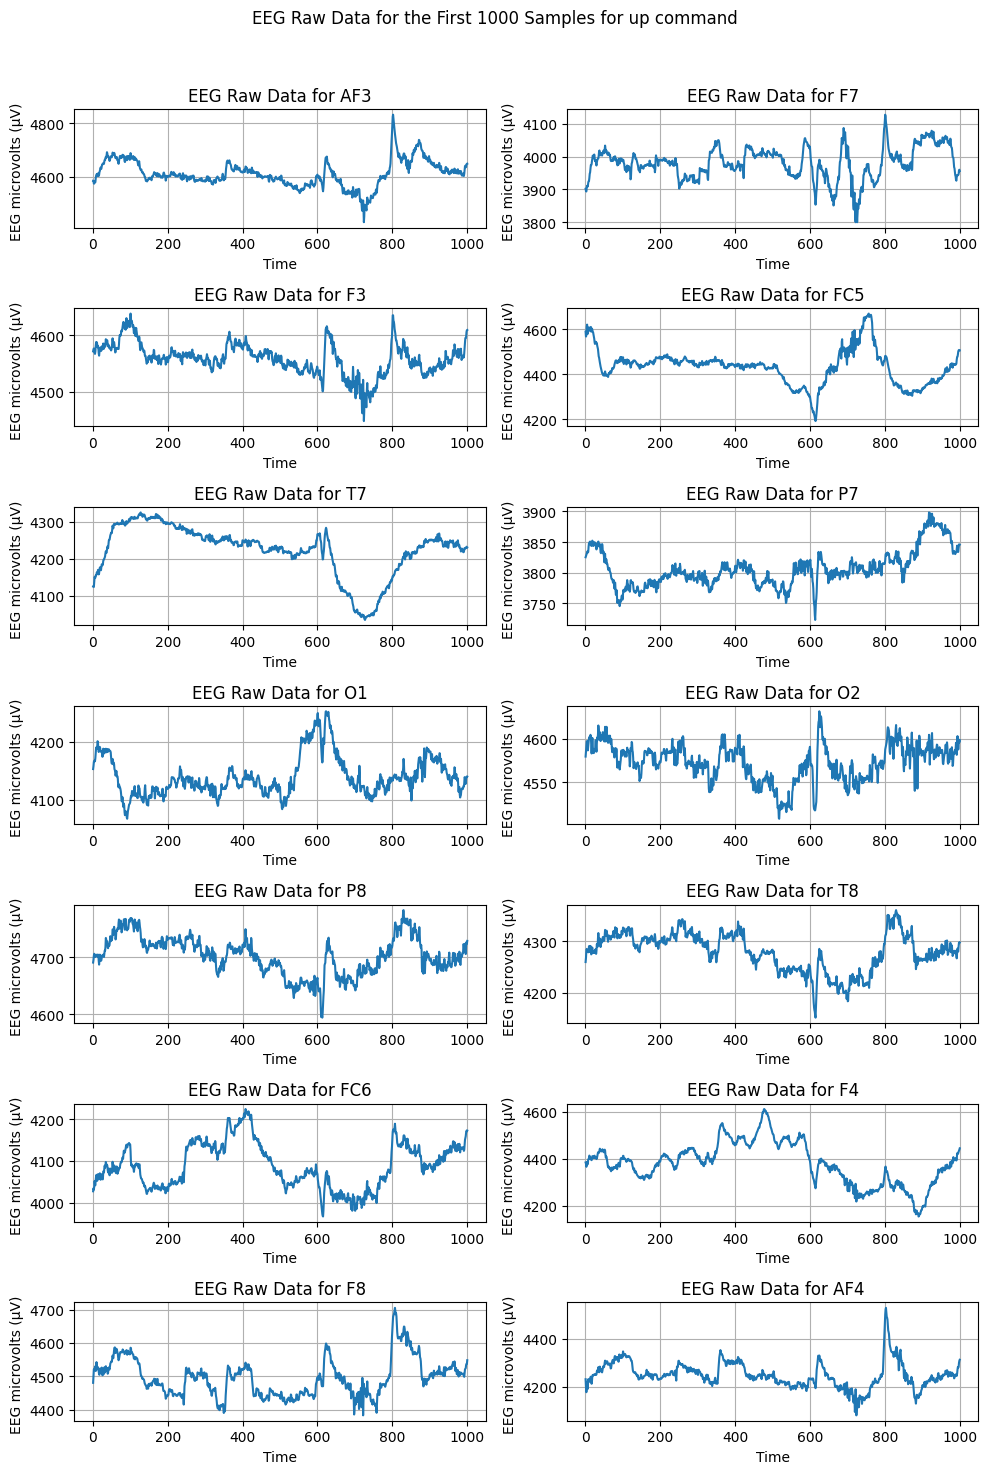

In [ ]:
plot_eeg_data(df_stress, num_rows=1000)

In [ ]:


def calculate_self_similarity(dataframe):
    # Extract EEG data columns
    eeg_data = dataframe.values

    # Calculate self-similarity
    self_similarity = round(np.mean(np.corrcoef(eeg_data, rowvar=False)), 2)

    return self_similarity
# Calculate self-similarity for the entire dataset
self_similarity = calculate_self_similarity(df_stress)

# Display the self-similarity value
print(f"Self-Similarity for the entire dataset: {self_similarity}")



Self-Similarity for the entire dataset: 0.3
